Min Validation Loss: 3.0831
Max HellaSwag Accuracy: 0.3013


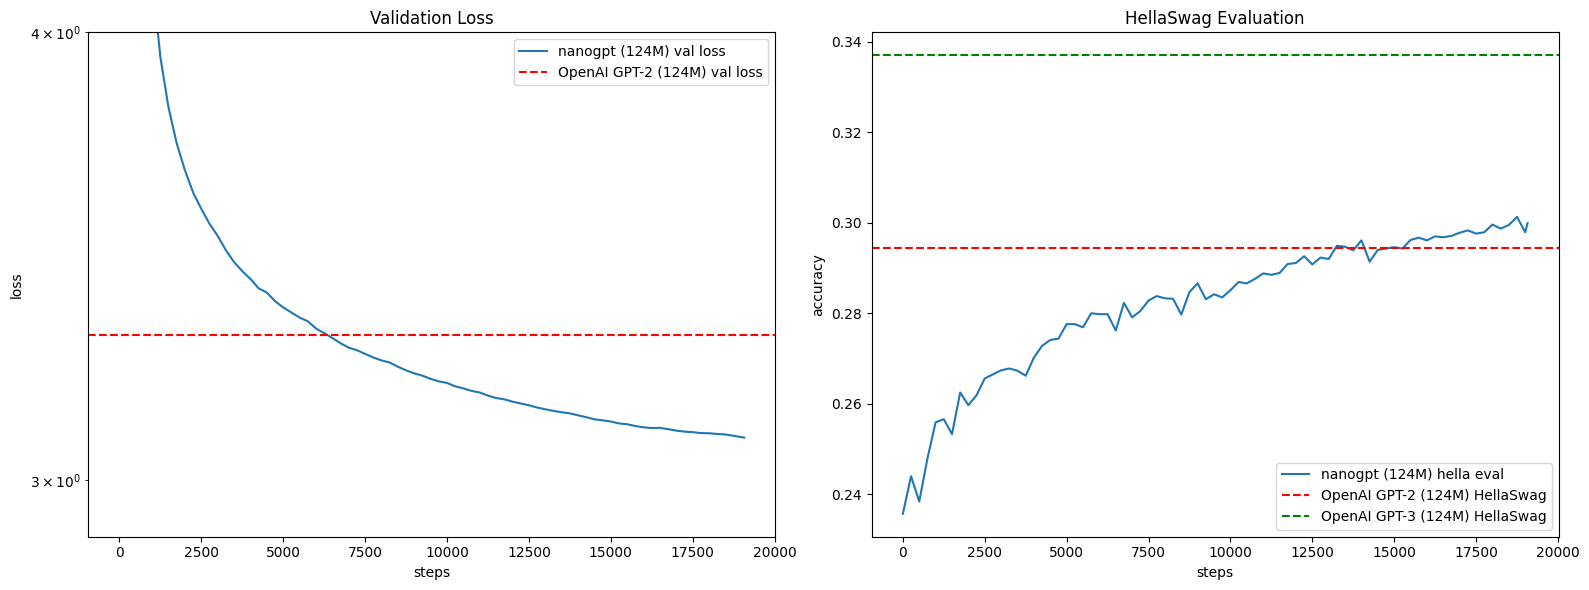

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# Parse the log file
streams = {"val": [], "hella": []}
for line in lines:
    step, stream, val = line.strip().split()
    streams[stream].append((int(step), float(val)))

# Prepare data for plotting
streams_xy = {k: list(zip(*sorted(v))) for k, v in streams.items()}

# Create figure
plt.figure(figsize=(16, 6))

# Panel 1: Validation Loss
plt.subplot(121)
xs, ys = streams_xy["val"]
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
if loss_baseline:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Validation Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag Evaluation
plt.subplot(122)
xs, ys = streams_xy["hella"]
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) hella eval')
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) HellaSwag")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) HellaSwag")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag Evaluation")
print("Max HellaSwag Accuracy:", max(ys))

# Show the plots
plt.tight_layout()
plt.show()

In [3]:
# Required Libraries
from contextlib import nullcontext  # For conditional context management
import torch  # PyTorch library for building and training models
import torch.nn as nn  # Neural network module in PyTorch
import torch.nn.functional as F  # Functional interface for neural network operations
from dataclasses import dataclass  # To create simple data structures
import math  # For mathematical computations
import tiktoken  # For tokenizing input text
import time  # To measure execution time
import inspect  # To inspect function signatures
import os  # For file and environment variable operations
import torch.distributed as dist  # For distributed training
from torch.nn.parallel import DistributedDataParallel as DDP  # DDP module for multi-GPU training
from hellaswag import render_example, iterate_examples  # Specific dataset functions
import numpy as np

# Path for input data and saving the model
path = ""  # Directory for saving/loading data and models

# Configuration for the GPT model
@dataclass
class GPTConfig:
    context_size: int = 1024  # Sequence length
    vocab_size: int = 50304  # Vocabulary size for tokenization (GPT-2 uses 50257)
    num_blocks: int = 12  # Number of transformer blocks
    num_heads: int = 12  # Number of attention heads
    embed_size: int = 768  # Size of embeddings
    dropout: float = 0.0  # Dropout rate for regularization
    bias: bool = True  # Use biases in linear layers

# Check if Distributed Data Parallel (DDP) is enabled
ddp = int(os.environ.get('RANK', -1)) != -1  # Check if running in a distributed environment
if ddp:
    # Initialize DDP settings
    dist.init_process_group(backend='nccl')  # Use NCCL backend for distributed training
    rank = int(os.environ['RANK'])  # Global rank of the process
    local_rank = int(os.environ['LOCAL_RANK'])  # Local rank of the process
    world_size = int(os.environ['WORLD_SIZE'])  # Total number of processes
    device = f'cuda:{local_rank}'  # Assign the local GPU
    device_type = 'cuda'
    torch.cuda.set_device(device)  # Set the device for this process
    is_master = (local_rank == 0)  # Identify the master process for logging
    if is_master:
        print("Distributed learning ON")
    print(f"Global Rank: {rank}, Local Rank: {local_rank}, World Size: {world_size}")
else:
    # Fallback for single-device training
    rank, local_rank, world_size = 0, 0, 1  # Default ranks and world size
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available, else CPU
    device_type = device
    is_master = True  # Single process acts as the master

    # Log the device being used
    if torch.cuda.is_available():
        print(f"Using device: {torch.cuda.get_device_name(0)} (CUDA)")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # Use Metal Performance Shaders on macOS
        print("Using device: MPS")
    else:
        print("Using device: CPU")

# Global training configurations
compiled = False  # Use PyTorch's Compiler
fp16 = True  # Enable mixed-precision training for faster computation
dtype = 'TF32'  # Default floating-point precision for matrix multiplication
total_batch_size = 524288  # Total number of tokens in a batch
batch_size_per_device = 64  # Number of sequences processed per GPU
seed = 1337  # Seed for reproducibility
eval_step_interval = 250  # Evaluate every 250 steps
eval_max_steps = 20  # Number of steps for evaluation
save_step = 5000  # Save model every 5000 steps

max_steps = 19073  # Total number of training steps
warmup_steps = 715  # Warmup steps for learning rate scheduler

max_lr = 6e-4  # Maximum learning rate
min_lr = max_lr * 0.1  # Minimum learning rate after decay

# Calculate gradient accumulation steps
grad_accum_steps = total_batch_size // (batch_size_per_device * GPTConfig().context_size * world_size)
if is_master:
    print("The desired amount of tokens in a single batch is:", total_batch_size)
    print("Gradient Accumulation Steps:", grad_accum_steps)

# GPT Model Components and Classes
class CasualSelfAttention(nn.Module):
    """
    Implements scaled dot-product attention with optional dropout and causal masking.
    """
    def __init__(self, config):
        super().__init__()
        # Projections for Query, Key, and Value
        self.c_attn = nn.Linear(config.embed_size, 3 * config.embed_size)
        self.c_proj = nn.Linear(config.embed_size, config.embed_size)  # Output projection
        self.num_heads = config.num_heads  # Number of attention heads
        self.embed_size = config.embed_size  # Embedding size
        self.dropout = config.dropout  # Dropout probability
        self.att_dropout = nn.Dropout(config.dropout)  # Dropout for attention scores
        self.residual_dropout = nn.Dropout(config.dropout)  # Dropout for residual connections
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')  # Check if Flash Attention is available
        if not self.flash:
            if is_master:
                print("WARNING: Using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask for slower attention implementation
            self.register_buffer("bias", torch.tril(torch.ones(config.context_size, config.context_size))
                                  .view(1, 1, config.context_size, config.context_size))
    
    def forward(self, x):
        # Input shape: (Batch size, Sequence length, Embedding size)
        B, T, C = x.size()  # Extract batch size (B), sequence length (T), and embedding size (C)

        # Compute Query, Key, Value projections
        qkv = self.c_attn(x)  # Linear projection to generate Q, K, V
        q, k, v = qkv.split(self.embed_size, dim=2)  # Split into query, key, and value

        # Reshape Q, K, V for multi-head attention
        q = q.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)  # (B, Heads, T, Head Size)
        k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        if self.flash:  # Fast attention (requires PyTorch >= 2.0)
            y = F.scaled_dot_product_attention(q, k, v, is_causal=True,
                                               dropout_p=self.dropout if self.training else 0)
        else:  # Slow attention (uses explicit causal mask)
            # Scaled dot-product attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # Scale by sqrt(head size)
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))  # Apply causal mask
            att = F.softmax(att, dim=-1)  # Softmax over the last dimension
            if self.training:
                att = self.att_dropout(att)  # Apply dropout to attention scores
            y = att @ v  # Compute weighted sum of values

        # Combine heads and project output
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reshape back to (B, T, C)
        y = self.c_proj(y)  # Final linear projection
        if self.training:
            y = self.residual_dropout(y)  # Apply dropout to output
        return y  # Return attention output

class MLP(nn.Module):
    """
    Multi-layer perceptron used in transformer blocks.
    """
    def __init__(self, config):
        super().__init__()
        # Two fully connected layers with a GeLU activation in between
        self.c_fc = nn.Linear(config.embed_size, 4 * config.embed_size, bias=config.bias)  # Expand dimension
        self.gelu = nn.GELU(approximate='tanh')  # GeLU activation function
        self.c_proj = nn.Linear(4 * config.embed_size, config.embed_size, bias=config.bias)  # Reduce dimension
        self.dropout = nn.Dropout(config.dropout)  # Dropout for regularization

    def forward(self, x):
        # Feedforward pass
        x = self.c_fc(x)  # First fully connected layer
        x = self.gelu(x)  # GeLU activation
        x = self.c_proj(x)  # Second fully connected layer
        if self.training:
            x = self.dropout(x)  # Apply dropout during training
        return x  # Return processed output

class Block(nn.Module):
    """
    Transformer block with attention and feed-forward layers.
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embed_size, bias=config.bias)  # Layer normalization before attention
        self.ln_2 = nn.LayerNorm(config.embed_size, bias=config.bias)  # Layer normalization before MLP
        self.attn = CasualSelfAttention(config)  # Causal self-attention module
        self.mlp = MLP(config)  # Multi-layer perceptron (feed-forward network)

    def forward(self, x):
        # Apply attention with residual connection
        x = x + self.attn(self.ln_1(x))  # LayerNorm -> Attention -> Residual
        # Apply feed-forward network with residual connection
        x = x + self.mlp(self.ln_2(x))  # LayerNorm -> MLP -> Residual
        return x  # Return processed output

class GPT(nn.Module):
    """
    GPT-like model implementation.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config  # Store configuration

        # Transformer components
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.embed_size),  # Token embeddings
            wpe=nn.Embedding(config.context_size, config.embed_size),  # Positional embeddings
            dropout=nn.Dropout(config.dropout),  # Dropout layer
            h=nn.ModuleList([Block(config) for _ in range(config.num_blocks)]),  # Stack of transformer blocks
            ln_f=nn.LayerNorm(config.embed_size, bias=config.bias)  # Final layer normalization
        ))

        self.lm_head = nn.Linear(config.embed_size, config.vocab_size, bias=False)  # Output layer for logits

        # Tie input embedding weights with the output layer
        self.transformer.wte.weight = self.lm_head.weight  # Weight tying

        # Initialize weights
        self.apply(self.init_weights)  # Apply weight initialization
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):  # Special initialization for projection layers
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.num_blocks))

    def init_weights(self, module):
        """
        Initialize weights for the model layers.
        """
        std = 0.02  # Standard deviation for initialization
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)  # Initialize weights with Gaussian
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)  # Initialize biases to zero
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)  # Initialize embeddings with Gaussian

    def forward(self, x, targets=None):
        """
        Forward pass for training and inference.
        """
        B, T = x.size()  # Batch size and sequence length

        # Combine token and positional embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=x.device)  # Positional indices
        pos_emb = self.transformer.wpe(pos)  # Positional embeddings
        token_emb = self.transformer.wte(x)  # Token embeddings
        x = pos_emb + token_emb  # Combine token and positional embeddings
        if self.training:
            x = self.transformer.dropout(x)  # Apply dropout during training

        # Apply transformer blocks
        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)  # Final layer normalization

        # Compute loss for training or logits for inference
        logits = self.lm_head(x)  # Compute logits for all tokens

        loss = None
        if targets is not None:  # Training mode
            # logits = self.lm_head(x)  # Compute logits for all tokens
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))  # Compute cross-entropy loss
        # else:  # Inference mode
        #     logits = self.lm_head(x[:, [-1], :])  # Predict next token logits (last token in the sequence)

        return logits, loss  # Return logits and loss (if applicable)

    def generate(self, tokens, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens given input tokens.
        """
        with torch.no_grad():  # Disable gradient computation
            for i in range(max_new_tokens):
                # Truncate sequence to context size if necessary
                tokens_cropped = tokens if tokens.size(1) <= self.config.context_size else tokens[:, -self.config.context_size:]
                logits, _ = self(tokens_cropped)  # Forward pass
                logits = logits[:, -1, :] / temperature  # Scale logits by temperature

                if top_k is not None:  # Apply top-k sampling
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))  # Top-k probabilities
                    logits[logits < v[:, [-1]]] = -float('Inf')  # Mask logits below the top-k threshold

                probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
                new_token = torch.multinomial(probs, num_samples=1)  # Sample next token
                tokens = torch.cat((tokens, new_token), dim=1)  # Append the new token to the sequence

        return tokens  # Return the generated tokens
    
    def configure_optimizers(self, weight_decay, learning_rate, betas, eps, device_type):
        """
        Configure the optimizer with different parameter groups.
        """
        # Collect all parameters and filter those that require gradients
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # Separate parameters into those with weight decay and those without
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]  # Weights in matrices (2D or higher)
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]  # Biases and normalization weights

        # Create optimizer parameter groups
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},  # Apply weight decay
            {'params': nodecay_params, 'weight_decay': 0.0}  # No weight decay
        ]

        # Log the number of parameters in each group
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        if is_master:
            print(f"Num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
            print(f"Num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        # Check if fused AdamW is available for better performance
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()

        # Create the AdamW optimizer
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, eps=eps, **extra_args)
        if is_master:
            print(f"Using fused AdamW: {use_fused}")

        return optimizer  # Return the configured optimizer

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        """
        Load a pretrained GPT model and initialize it with specified configuration.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}  # Ensure valid model type
        override_args = override_args or {}  # Use provided overrides or default to an empty dict

        # Validate that only the dropout rate can be overridden
        assert all(k == 'dropout' for k in override_args)

        from transformers import GPT2LMHeadModel  # Import Hugging Face's GPT2 model

        print("Loading weights from pretrained GPT: %s" % model_type)

        # Model configurations based on model type
        config_args = {
            'gpt2': dict(num_blocks=12, num_heads=12, embed_size=768),  # 124M parameters
            'gpt2-medium': dict(num_blocks=24, num_heads=16, embed_size=1024),  # 350M parameters
            'gpt2-large': dict(num_blocks=36, num_heads=20, embed_size=1280),  # 774M parameters
            'gpt2-xl': dict(num_blocks=48, num_heads=25, embed_size=1600)  # 1558M parameters
        }[model_type]

        # Enforce default configurations
        print("Forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257  # Fixed vocabulary size for GPT models
        config_args['context_size'] = 1024  # Fixed sequence length
        config_args['bias'] = True  # Always use bias

        # Override dropout if specified
        if 'dropout' in override_args:
            print(f"Overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']

        # Initialize a new GPT model with the specified configuration
        config = GPTConfig(**config_args)
        model = GPT(config)

        # Load pretrained weights from Hugging Face
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # Map weights from Hugging Face model to custom GPT implementation
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']  # Layers to transpose
        for k in model.state_dict().keys():
            if k in transposed:
                with torch.no_grad():
                    model.state_dict()[k].copy_(sd_hf[k].t())  # Transpose weights
            else:
                with torch.no_grad():
                    model.state_dict()[k].copy_(sd_hf[k])  # Directly copy weights

        return model  # Return the initialized GPT model

Using device: CPU
The desired amount of tokens in a single batch is: 524288
Gradient Accumulation Steps: 8


In [ ]:
import torch
import tiktoken
# Load saved model checkpoint
path = 'log/'
checkpoint_path = path + "model_19072.pt"
device = 'cpu'

# Initialize model with GPT configuration
config = GPTConfig(vocab_size=50304)
model = GPT(config)
model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model'])
model.to(device)
model.eval()

# Load tokenizer
enc = tiktoken.get_encoding('gpt2')

# Input prompt
prompt = "Hello, I'm a language model,"
tokens = enc.encode(prompt)
x = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

# Generate new tokens
max_new_tokens = 100
outputs = model.generate(x, max_new_tokens=max_new_tokens, temperature=1.0, top_k=50)

# Decode and print outputs
outputs = [enc.decode(output.tolist()) for output in outputs]
for text in outputs:
    print("Generated Text:\n", text)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26452\3559199625.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_loca

Generated Text:
 Hello, I'm a language model, I have to write a language, and an expression... But, this is a really fun way to approach writing! You get to ask questions, find useful solutions, make ideas flow. What do you want to do?
I am going to begin to introduce myself and my ideas into my blog, so this is going to be a series of blog posts that I will introduce myself and my ideas together, all by myself and by the language learning teacher!
The idea of a blog is not to
